In [6]:
import pickle 
file_path_test = r"D:\ki 4\AIL303M\dự án\buzz 2\output\Test_chroma_features.pkl"
file_path_train = r"D:\ki 4\AIL303M\dự án\buzz 2\output\Train_chroma_features.pkl"
file_path_val = r"D:\ki 4\AIL303M\dự án\buzz 2\output\Val_chroma_features.pkl"

# Load the pickle files
with open(file_path_train, "rb") as f:
    train_data = pickle.load(f)

with open(file_path_val, "rb") as f:
    val_data = pickle.load(f)

with open(file_path_test, "rb") as f:
    test_data = pickle.load(f)

In [7]:
import numpy as np
import pandas as pd
def process_data(data):
    X = []
    y = []
    for item in data:
        chroma = np.mean(item['chroma'], axis=1)  
        label = item['category'] 
        X.append(chroma)
        y.append(label)
    return np.array(X), np.array(y)


X_train, y_train = process_data(train_data)
X_val, y_val = process_data(val_data)
X_test, y_test = process_data(test_data)

# Convert to DataFrame for correlation analysis
X_train_df = pd.DataFrame(X_train)
X_val_df = pd.DataFrame(X_val)
X_test_df = pd.DataFrame(X_test)


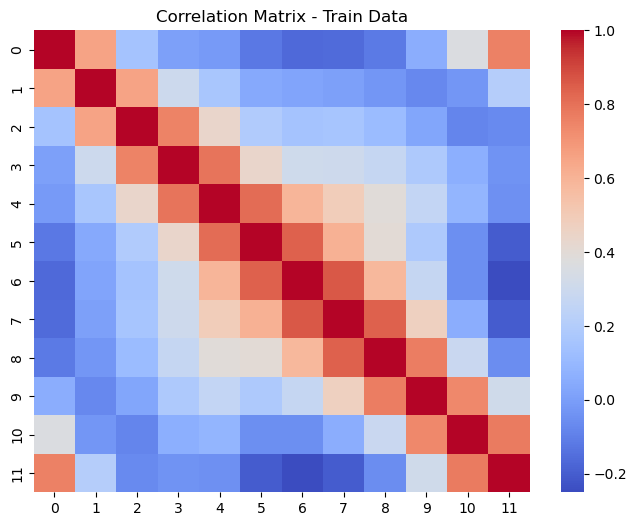

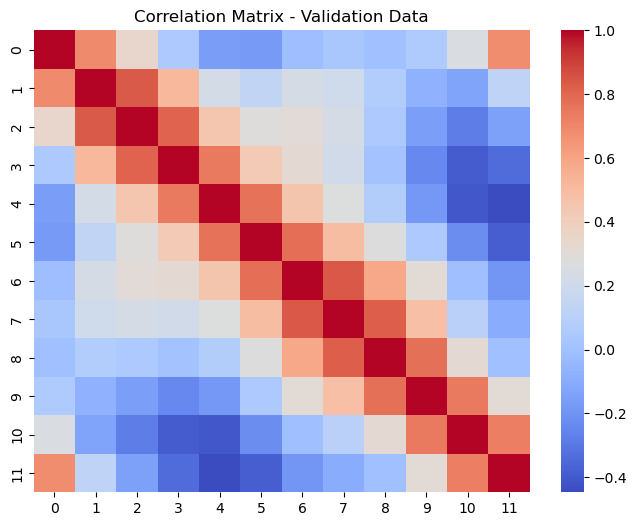

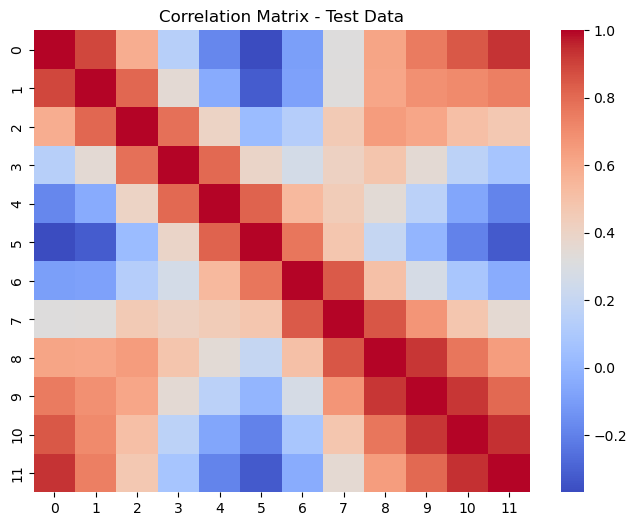

In [8]:
corr_train = X_train_df.corr()
corr_val = X_val_df.corr()
corr_test = X_test_df.corr()
import matplotlib.pyplot as plt
import seaborn as sns
# Vẽ heatmap cho tập Train
plt.figure(figsize=(8,6))
sns.heatmap(corr_train, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Correlation Matrix - Train Data")
plt.show()

# Vẽ heatmap cho tập Validation
plt.figure(figsize=(8,6))
sns.heatmap(corr_val, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Correlation Matrix - Validation Data")
plt.show()

# Vẽ heatmap cho tập Test
plt.figure(figsize=(8,6))
sns.heatmap(corr_test, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Correlation Matrix - Test Data")
plt.show()


## CORR

In [9]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score

# Tìm ngưỡng tối ưu để loại bỏ các cột có tương quan cao
best_threshold = None
best_accuracy = 0
best_cols_to_drop = set()
thresholds = [0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

for threshold in thresholds:
    # Tính ma trận tương quan
    corr_matrix = X_train_df.corr().abs()
    
    # Xác định các feature có tương quan cao hơn threshold
    high_corr = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns
                 if i != j and corr_matrix.loc[i, j] > threshold]
    
    # Chọn cột để loại bỏ (mặc định bỏ cột thứ 2 trong từng cặp)
    cols_to_drop = set(j for _, j in high_corr)
    
    # Loại bỏ các cột đã chọn
    X_train_filtered = X_train_df.drop(columns=cols_to_drop, errors='ignore')
    X_val_filtered = X_val_df.drop(columns=cols_to_drop, errors='ignore')

    # Huấn luyện mô hình SVM với tập train đã lọc
    model = SVC(kernel='linear', random_state=42)
    scores = cross_val_score(model, X_train_filtered, y_train, cv=5, scoring='accuracy')
    mean_accuracy = np.mean(scores)

    # Cập nhật threshold tối ưu
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_threshold = threshold
        best_cols_to_drop = cols_to_drop

print(f"\nThreshold tối ưu: {best_threshold}")
print(f"Số lượng cột bị loại bỏ: {len(best_cols_to_drop)}")

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_df.drop(columns=best_cols_to_drop, errors='ignore').values)
X_val_final = scaler.transform(X_val_df.drop(columns=best_cols_to_drop, errors='ignore').values)
X_test_final = scaler.transform(pd.DataFrame(X_test).drop(columns=best_cols_to_drop, errors='ignore').values)

# Chọn số lượng thành phần chính giữ lại 95% phương sai
explained_variance_ratio = np.cumsum(PCA().fit(X_train_final).explained_variance_ratio_)
optimal_components = np.argmax(explained_variance_ratio >= 0.95) + 1
print(f"Số lượng thành phần chính tối ưu: {optimal_components}")

# Áp dụng PCA với số lượng thành phần chính tối ưu
pca = PCA(n_components=optimal_components)
X_train_pca = pca.fit_transform(X_train_final)
X_val_pca = pca.transform(X_val_final)
X_test_pca = pca.transform(X_test_final)

# Khởi tạo các mô hình
models = {
    "SVM": SVC(kernel='rbf', C=10, degree=5, gamma='auto', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7, weights='distance', p=2),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=300, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42)
}

print("\nĐánh giá các mô hình riêng lẻ:")
for name, model in models.items():
    model.fit(X_train_pca, y_train)
    val_acc = accuracy_score(y_val, model.predict(X_val_pca))
    val_f1 = f1_score(y_val, model.predict(X_val_pca), average='weighted')
    test_acc = accuracy_score(y_test, model.predict(X_test_pca))
    test_f1 = f1_score(y_test, model.predict(X_test_pca), average='weighted')
    print(f"{name} - Validation Accuracy: {val_acc:.4f}, Validation F1-score: {val_f1:.4f}")
    print(f"{name} - Test Accuracy: {test_acc:.4f}, Test F1-score: {test_f1:.4f}\n")
    
    
# ✅ Soft Voting (Trung bình xác suất dự đoán)
soft_voting = VotingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    voting='soft'
)

# ✅ Hard Voting (Dự đoán theo đa số)
hard_voting = VotingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    voting='hard'
)

# ✅ Weighted Voting (Gán trọng số cho mô hình)
weights = [2, 1, 3, 3, 1, 2]  
weighted_voting = VotingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    voting='soft',
    weights=weights
)

# ✅ Stacking với Logistic Regression
stacking_lr = StackingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    final_estimator=LogisticRegression(random_state=42)
)

# ✅ Stacking với Random Forest
stacking_rf = StackingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42)
)

# ✅ Stacking với Extra Trees
stacking_extra = StackingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    final_estimator=ExtraTreesClassifier(n_estimators=100, random_state=42)
)

# ✅ Đánh giá các mô hình ensemble
ensemble_models = {
    "Soft Voting": soft_voting,
    "Hard Voting": hard_voting,
    "Weighted Voting": weighted_voting,
    "Stacking (LR)": stacking_lr,
    "Stacking (RF)": stacking_rf,
    "Stacking (Extra Tree)": stacking_extra
}

# Huấn luyện và đánh giá mô hình
for name, model in ensemble_models.items():
    model.fit(X_train_pca, y_train)
    val_acc = accuracy_score(y_val, model.predict(X_val_pca))
    val_f1 = f1_score(y_val, model.predict(X_val_pca), average='weighted')
    test_acc = accuracy_score(y_test, model.predict(X_test_pca))
    test_f1 = f1_score(y_test, model.predict(X_test_pca), average='weighted')
    print(f"{name} - Validation Accuracy: {val_acc:.4f}, Validation F1-score: {val_f1:.4f}")
    print(f"{name} - Test Accuracy: {test_acc:.4f}, Test F1-score: {test_f1:.4f}\n")


Threshold tối ưu: 0.9
Số lượng cột bị loại bỏ: 0
Số lượng thành phần chính tối ưu: 6

Đánh giá các mô hình riêng lẻ:
SVM - Validation Accuracy: 0.5424, Validation F1-score: 0.5347
SVM - Test Accuracy: 0.9102, Test F1-score: 0.9102

KNN - Validation Accuracy: 0.5219, Validation F1-score: 0.5155
KNN - Test Accuracy: 0.9144, Test F1-score: 0.9144

Random Forest - Validation Accuracy: 0.5365, Validation F1-score: 0.5302
Random Forest - Test Accuracy: 0.9183, Test F1-score: 0.9183

Gradient Boosting - Validation Accuracy: 0.5383, Validation F1-score: 0.5278
Gradient Boosting - Test Accuracy: 0.9129, Test F1-score: 0.9129

Naive Bayes - Validation Accuracy: 0.4437, Validation F1-score: 0.4359
Naive Bayes - Test Accuracy: 0.9493, Test F1-score: 0.9492

Extra Trees - Validation Accuracy: 0.5307, Validation F1-score: 0.5255
Extra Trees - Test Accuracy: 0.9229, Test F1-score: 0.9228

Soft Voting - Validation Accuracy: 0.5172, Validation F1-score: 0.5097
Soft Voting - Test Accuracy: 0.9309, Test

## feature importantimportant

In [10]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier  

# Huấn luyện mô hình Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)  
rf.fit(X_train, y_train)

# Lấy độ quan trọng của từng đặc trưng
feature_importances = rf.feature_importances_

# Chuyển thành DataFrame để dễ xem
feature_ranking = pd.DataFrame({
    'Feature': range(len(feature_importances)),  
    'Importance': feature_importances
})

# Sắp xếp theo độ quan trọng từ cao xuống thấp
feature_ranking = feature_ranking.sort_values(by='Importance', ascending=False)

# Hiển thị kết quả
print(feature_ranking)

    Feature  Importance
0         0    0.202597
8         8    0.123827
7         7    0.120252
1         1    0.080569
11       11    0.079349
3         3    0.074533
4         4    0.071084
6         6    0.058650
5         5    0.055173
9         9    0.050838
10       10    0.042455
2         2    0.040673


In [11]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Nếu X_train là NumPy array, chuyển thành DataFrame
X_train_df = pd.DataFrame(X_train, columns=[f'Feature_{i}' for i in range(X_train.shape[1])])


k_list = [3,5,7,9]  
best_score = 0
best_k = None
best_features = None

for k in k_list:
    # Chọn Top k feature bằng phương pháp thống kê f_classif
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)

    # Lấy danh sách feature quan trọng nhất
    selected_feature_names = X_train_df.columns[selector.get_support()].tolist()

    # Dùng Cross-Validation để đánh giá mô hình
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='accuracy')

    mean_score = np.mean(scores)
    print(f"Top {k} Features - CV Accuracy={mean_score:.4f}")

    # Cập nhật feature tốt nhất
    if mean_score > best_score:
        best_score = mean_score
        best_k = k
        best_features = selected_feature_names

# Chọn lại dữ liệu chỉ với best_k features
print(f"\n🔹 Chọn {best_k} features tốt nhất với CV Accuracy={best_score:.4f}")
X_train_selected = X_train_df[best_features]
X_val_selected = pd.DataFrame(X_val, columns=X_train_df.columns)[best_features]
X_test_selected = pd.DataFrame(X_test, columns=X_train_df.columns)[best_features]



Top 3 Features - CV Accuracy=0.8378
Top 5 Features - CV Accuracy=0.8661
Top 7 Features - CV Accuracy=0.8758
Top 9 Features - CV Accuracy=0.8891

🔹 Chọn 9 features tốt nhất với CV Accuracy=0.8891


In [13]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier,
    VotingClassifier, StackingClassifier
)
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Ensure X_train is a DataFrame for consistent feature names
if not isinstance(X_train, pd.DataFrame):
    X_train_df = pd.DataFrame(X_train, columns=[f'Feature_{i}' for i in range(X_train.shape[1])])
else:
    X_train_df = X_train.copy()

# Feature selection: Choose top k features using f_classif
k_list = [3, 5, 7, 9]
best_score = 0
best_k = None
best_features = None

for k in k_list:
    # Select top k features
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected_temp = selector.fit_transform(X_train_df, y_train)
    selected_feature_names = X_train_df.columns[selector.get_support()].tolist()

    # Evaluate using cross-validation with RandomForestClassifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = cross_val_score(model, X_train_selected_temp, y_train, cv=5, scoring='accuracy')
    mean_score = np.mean(scores)
    print(f"Top {k} Features - CV Accuracy = {mean_score:.4f}")

    if mean_score > best_score:
        best_score = mean_score
        best_k = k
        best_features = selected_feature_names

print(f"\n🔹 Selected top {best_k} features with CV Accuracy = {best_score:.4f}")
X_train_selected = X_train_df[best_features]

if not isinstance(X_val, pd.DataFrame):
    X_val_df = pd.DataFrame(X_val, columns=X_train_df.columns)
else:
    X_val_df = X_val.copy()

if not isinstance(X_test, pd.DataFrame):
    X_test_df = pd.DataFrame(X_test, columns=X_train_df.columns)
else:
    X_test_df = X_test.copy()

# Select the best features for validation and test sets
X_val_selected = X_val_df[best_features]
X_test_selected = X_test_df[best_features]

# Define base models
models = {
    "SVM": SVC(kernel='rbf', C=10, degree=5, gamma='auto', random_state=42, probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=7, weights='distance', p=2),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=300, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42)
}

# Build ensemble models

# Soft Voting: Average probabilities of the base models
soft_voting_model = VotingClassifier(estimators=list(models.items()), voting='soft')
soft_voting_model.fit(X_train_selected, y_train)

# Hard Voting: Majority vote from the base models
hard_voting_model = VotingClassifier(estimators=list(models.items()), voting='hard')
hard_voting_model.fit(X_train_selected, y_train)

# Weighted Voting: Provide custom weights for each model
weights = {'SVM': 1.0, 'KNN': 1.5, 'Random Forest': 2.0, 'Gradient Boosting': 2.5, 'Naive Bayes': 1.0, 'Extra Trees': 1.5}
weighted_voting_model = VotingClassifier(
    estimators=list(models.items()),
    voting='soft',
    weights=[weights[name] for name in models.keys()]
)
weighted_voting_model.fit(X_train_selected, y_train)

# Stacking: Using Logistic Regression as the meta-model
stacking_model_lr = StackingClassifier(estimators=list(models.items()),
                                       final_estimator=LogisticRegression())
stacking_model_lr.fit(X_train_selected, y_train)

# Stacking with Random Forest as meta-model
stacking_model_rf = StackingClassifier(estimators=list(models.items()),
                                       final_estimator=RandomForestClassifier(n_estimators=100, random_state=42))
stacking_model_rf.fit(X_train_selected, y_train)

# Stacking with Extra Trees as meta-model
stacking_model_et = StackingClassifier(estimators=list(models.items()),
                                       final_estimator=ExtraTreesClassifier(n_estimators=100, random_state=42))
stacking_model_et.fit(X_train_selected, y_train)

# Dictionary of ensemble models
ensemble_models = {
    "Soft Voting": soft_voting_model,
    "Hard Voting": hard_voting_model,
    "Weighted Voting": weighted_voting_model,
    "Stacking (LR)": stacking_model_lr,
    "Stacking (RF)": stacking_model_rf,
    "Stacking (Extra Trees)": stacking_model_et
}

# Evaluate individual base models
results = {}
best_model = None
best_model_score = 0

for name, model in models.items():
    model.fit(X_train_selected, y_train)
    
    y_val_pred = model.predict(X_val_selected)
    y_test_pred = model.predict(X_test_selected)
    
    val_acc = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred, average="weighted")
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average="weighted")
    
    results[name] = {
        "Validation Accuracy": val_acc,
        "Validation F1-score": val_f1,
        "Test Accuracy": test_acc,
        "Test F1-score": test_f1
    }
    
    if val_acc > best_model_score:
        best_model_score = val_acc
        best_model = name

print("\n🔹 Individual Model Performance on Validation and Test Sets:")
for name, scores in results.items():
    print(f"{name}:")
    print(f"  - Validation Accuracy: {scores['Validation Accuracy']:.4f}, Validation F1-score: {scores['Validation F1-score']:.4f}")
    print(f"  - Test Accuracy: {scores['Test Accuracy']:.4f}, Test F1-score: {scores['Test F1-score']:.4f}\n")

print(f"🔥 Best individual model: {best_model} with Validation Accuracy = {best_model_score:.4f}")

# Evaluate ensemble models
ensemble_results = {}
for name, model in ensemble_models.items():
    y_val_pred = model.predict(X_val_selected)
    y_test_pred = model.predict(X_test_selected)
    
    val_acc = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred, average="weighted")
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average="weighted")
    
    ensemble_results[name] = {
        "Validation Accuracy": val_acc,
        "Validation F1-score": val_f1,
        "Test Accuracy": test_acc,
        "Test F1-score": test_f1
    }

print("\n🔹 Ensemble Model Performance on Validation and Test Sets:")
for name, scores in ensemble_results.items():
    print(f"{name}:")
    print(f"  - Validation Accuracy: {scores['Validation Accuracy']:.4f}, Validation F1-score: {scores['Validation F1-score']:.4f}")
    print(f"  - Test Accuracy: {scores['Test Accuracy']:.4f}, Test F1-score: {scores['Test F1-score']:.4f}\n")


Top 3 Features - CV Accuracy = 0.8378
Top 5 Features - CV Accuracy = 0.8661
Top 7 Features - CV Accuracy = 0.8758
Top 9 Features - CV Accuracy = 0.8891

🔹 Selected top 9 features with CV Accuracy = 0.8891

🔹 Individual Model Performance on Validation and Test Sets:
SVM:
  - Validation Accuracy: 0.4902, Validation F1-score: 0.4868
  - Test Accuracy: 0.9441, Test F1-score: 0.9441

KNN:
  - Validation Accuracy: 0.4801, Validation F1-score: 0.4664
  - Test Accuracy: 0.9280, Test F1-score: 0.9280

Random Forest:
  - Validation Accuracy: 0.4812, Validation F1-score: 0.4645
  - Test Accuracy: 0.9507, Test F1-score: 0.9507

Gradient Boosting:
  - Validation Accuracy: 0.4873, Validation F1-score: 0.4791
  - Test Accuracy: 0.9495, Test F1-score: 0.9494

Naive Bayes:
  - Validation Accuracy: 0.4205, Validation F1-score: 0.4184
  - Test Accuracy: 0.8241, Test F1-score: 0.8187

Extra Trees:
  - Validation Accuracy: 0.4691, Validation F1-score: 0.4554
  - Test Accuracy: 0.9490, Test F1-score: 0.9490

## fisher

       Feature  Fisher Criterion  Ranking
7    Feature_7          0.361168        1
8    Feature_8          0.360124        2
0    Feature_0          0.277402        3
6    Feature_6          0.188072        4
4    Feature_4          0.162676        5
3    Feature_3          0.148476        6
9    Feature_9          0.111032        7
5    Feature_5          0.103886        8
11  Feature_11          0.102112        9
1    Feature_1          0.052009       10
2    Feature_2          0.027103       11
10  Feature_10          0.000400       12

Mean Fisher Criterion: 0.157872


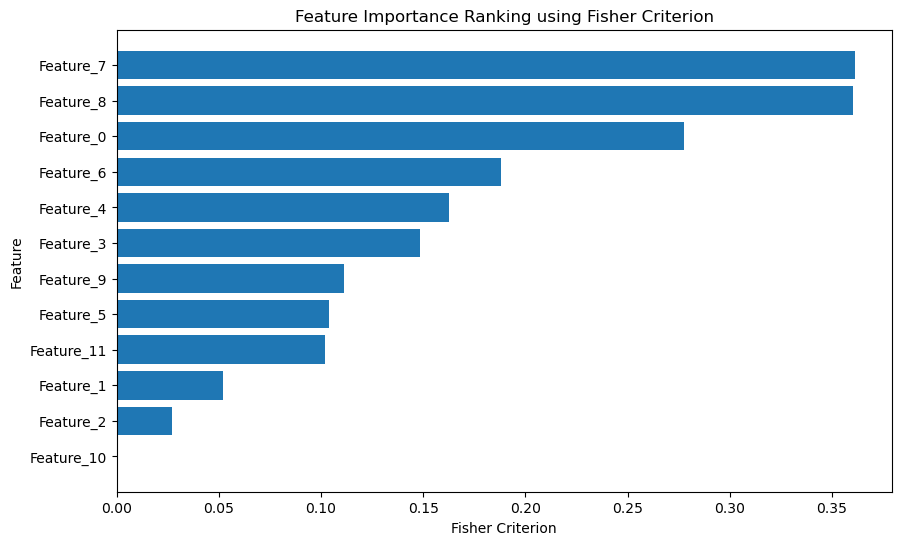

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Nếu X_train là NumPy array, chuyển thành DataFrame với tên cột phù hợp
X_train_df = pd.DataFrame(X_train, columns=[f'Feature_{i}' for i in range(X_train.shape[1])])

# Hàm tính Fisher Criterion cho mỗi đặc trưng
def fisher_criterion(X, y):
    classes = np.unique(y)
    class_means = []  
    class_vars = []   # Phương sai của từng lớp
    class_sizes = []  # Số mẫu trong từng lớp
    
    # Tính toán trung bình và phương sai của từng lớp
    for c in classes:
        X_c = X[y == c]
        class_means.append(np.mean(X_c, axis=0))
        class_vars.append(np.var(X_c, axis=0))
        class_sizes.append(X_c.shape[0])
    
    # Tính giá trị trung bình toàn bộ dữ liệu
    mu_total = np.mean(X, axis=0)

    fisher_scores = []
    
    for feature_idx in range(X.shape[1]):  
        # Phương sai giữa các lớp cho đặc trưng này
        sb = np.sum(np.array(class_sizes) * (np.array(class_means)[:, feature_idx] - mu_total[feature_idx])**2)
        
        # Phương sai trong các lớp cho đặc trưng này
        sw = np.sum(np.array(class_sizes) * np.array(class_vars)[:, feature_idx])
        
        # Fisher Criterion
        fisher_score = sb / sw
        fisher_scores.append(fisher_score)
    
    return fisher_scores

# Tính Fisher Criterion cho các đặc trưng
fisher_scores = fisher_criterion(X_train, y_train)

# Tạo DataFrame với tên đặc trưng và Fisher Criterion
feature_importance_df = pd.DataFrame({
    'Feature': X_train_df.columns,  # Tên cột của X_train_df
    'Fisher Criterion': fisher_scores
})

# Sắp xếp các đặc trưng theo Fisher Criterion (từ cao đến thấp)
feature_importance_df = feature_importance_df.sort_values(by='Fisher Criterion', ascending=False)

# Thêm cột Ranking
feature_importance_df['Ranking'] = range(1, len(feature_importance_df) + 1)

# In kết quả
print(feature_importance_df)

# Tính giá trị trung bình của Fisher Criterion
fisher_mean = feature_importance_df['Fisher Criterion'].mean()
print(f"\nMean Fisher Criterion: {fisher_mean:.6f}")

# Vẽ biểu đồ độ quan trọng của các đặc trưng (dựa trên Fisher Criterion)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Fisher Criterion'])
plt.xlabel('Fisher Criterion')
plt.ylabel('Feature')
plt.title('Feature Importance Ranking using Fisher Criterion')
plt.gca().invert_yaxis()  # Đảo chiều y-axis để đặc trưng có Fisher Criterion cao ở trên cùng
plt.show()



In [15]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd

# Nếu X_train là NumPy array, chuyển thành DataFrame
X_train_df = pd.DataFrame(X_train, columns=[f'Feature_{i}' for i in range(X_train.shape[1])])

k_list = [3, 5, 7, 9]  
best_k = None
best_score = 0
best_features = None

# Duyệt qua các giá trị k để tìm số lượng features tối ưu
for k in k_list:
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    
    selected_feature_names = X_train_df.columns[selector.get_support()].tolist()

    # Dùng K-Fold Cross-Validation để đánh giá mô hình với RandomForest
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Số folds cố định = 5
    scores = cross_val_score(model, X_train_selected, y_train, cv=kf, scoring='accuracy')

    mean_score = np.mean(scores)
    print(f"Top {k} Features - CV Accuracy={mean_score:.4f}")

    # Cập nhật số lượng feature tối ưu nhất
    if mean_score > best_score:
        best_score = mean_score
        best_k = k
        best_features = selected_feature_names

# Chạy lại SelectKBest với best_k
selector = SelectKBest(score_func=f_classif, k=best_k)
X_train_selected = selector.fit_transform(X_train, y_train)

# Chuyển đổi X_val và X_test thành DataFrame và chọn đúng feature
X_val_df = pd.DataFrame(X_val, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_train_df.columns)

X_val_selected = X_val_df[best_features].values
X_test_selected = X_test_df[best_features].values

# Danh sách mô hình để thử nghiệm
models = {
    "SVM": SVC(kernel='rbf', C=10, degree=5, gamma='auto', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7, weights='distance', p=2),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=300, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42)
}

# Huấn luyện & Đánh giá Accuracy & F1-score
results = {}
best_model = None
best_model_score = 0

for name, model in models.items():
    model.fit(X_train_selected, y_train)
    
    # Dự đoán trên Validation & Test
    y_val_pred = model.predict(X_val_selected)
    y_test_pred = model.predict(X_test_selected)
    
    # Tính Accuracy & F1-score
    val_acc = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred, average="weighted")
    
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average="weighted")
    
    results[name] = {
        "Validation Accuracy": val_acc,
        "Validation F1-score": val_f1,
        "Test Accuracy": test_acc,
        "Test F1-score": test_f1
    }
    
    # Cập nhật mô hình tốt nhất theo Validation Accuracy
    if val_acc > best_model_score:
        best_model_score = val_acc
        best_model = name

# In kết quả
print("\n🔹 Kết Quả Accuracy & F1-score Trên Validation & Test:")
for name, scores in results.items():
    print(f"{name}:")
    print(f"  - Validation Accuracy: {scores['Validation Accuracy']:.4f}, Validation F1-score: {scores['Validation F1-score']:.4f}")
    print(f"  - Test Accuracy: {scores['Test Accuracy']:.4f}, Test F1-score: {scores['Test F1-score']:.4f}\n")

print(f"🔥 Mô hình tốt nhất: {best_model} với Validation Accuracy = {best_model_score:.4f}")


Top 3 Features - CV Accuracy=0.8598
Top 5 Features - CV Accuracy=0.9017
Top 7 Features - CV Accuracy=0.9183
Top 9 Features - CV Accuracy=0.9341

🔹 Kết Quả Accuracy & F1-score Trên Validation & Test:
SVM:
  - Validation Accuracy: 0.4902, Validation F1-score: 0.4868
  - Test Accuracy: 0.9441, Test F1-score: 0.9441

KNN:
  - Validation Accuracy: 0.4801, Validation F1-score: 0.4664
  - Test Accuracy: 0.9280, Test F1-score: 0.9280

Random Forest:
  - Validation Accuracy: 0.4812, Validation F1-score: 0.4645
  - Test Accuracy: 0.9507, Test F1-score: 0.9507

Gradient Boosting:
  - Validation Accuracy: 0.4873, Validation F1-score: 0.4791
  - Test Accuracy: 0.9495, Test F1-score: 0.9494

Naive Bayes:
  - Validation Accuracy: 0.4205, Validation F1-score: 0.4184
  - Test Accuracy: 0.8241, Test F1-score: 0.8187

Extra Trees:
  - Validation Accuracy: 0.4691, Validation F1-score: 0.4554
  - Test Accuracy: 0.9490, Test F1-score: 0.9490

🔥 Mô hình tốt nhất: SVM với Validation Accuracy = 0.4902


In [16]:

# ✅ Cấu hình lại danh sách mô hình
models = {
    "SVM": SVC(kernel='rbf', C=10, degree=5, gamma='auto', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7, weights='distance', p=2),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=300, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42)
}

# ✅ Soft Voting (Trung bình xác suất dự đoán)
soft_voting = VotingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    voting='soft'
)

# ✅ Hard Voting (Dự đoán theo đa số)
hard_voting = VotingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    voting='hard'
)

# ✅ Weighted Voting (Gán trọng số cho mô hình)
weights = [2, 1, 3, 3, 1, 2]  
weighted_voting = VotingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    voting='soft',
    weights=weights
)

# ✅ Stacking với Logistic Regression
stacking_lr = StackingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    final_estimator=LogisticRegression(random_state=42)
)

# ✅ Stacking với Random Forest
stacking_rf = StackingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42)
)

# ✅ Stacking với Extra Trees
stacking_extra = StackingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    final_estimator=ExtraTreesClassifier(n_estimators=100, random_state=42)
)

# ✅ Đánh giá các mô hình ensemble
ensemble_models = {
    "Soft Voting": soft_voting,
    "Hard Voting": hard_voting,
    "Weighted Voting": weighted_voting,
    "Stacking (LR)": stacking_lr,
    "Stacking (RF)": stacking_rf,
    "Stacking (Extra Tree)": stacking_extra
}

# ✅ Huấn luyện & đánh giá các mô hình ensemble
ensemble_results = {}
best_ensemble_model = None
best_ensemble_score = 0

for name, model in ensemble_models.items():
    model.fit(X_train_selected, y_train)

    # Dự đoán trên Validation & Test
    y_val_pred = model.predict(X_val_selected)
    y_test_pred = model.predict(X_test_selected)

    # Tính Accuracy & F1-score
    val_acc = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred, average="weighted")

    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average="weighted")

    ensemble_results[name] = {
        "Validation Accuracy": val_acc,
        "Validation F1-score": val_f1,
        "Test Accuracy": test_acc,
        "Test F1-score": test_f1
    }

    # Cập nhật mô hình ensemble tốt nhất theo Validation Accuracy
    if val_acc > best_ensemble_score:
        best_ensemble_score = val_acc
        best_ensemble_model = name

# ✅ In kết quả
print("\n🔹 Kết Quả Ensemble Learning trên Validation & Test:")
for name, scores in ensemble_results.items():
    print(f"{name}:")
    print(f"  - Validation Accuracy: {scores['Validation Accuracy']:.4f}, Validation F1-score: {scores['Validation F1-score']:.4f}")
    print(f"  - Test Accuracy: {scores['Test Accuracy']:.4f}, Test F1-score: {scores['Test F1-score']:.4f}\n")

print(f"🔥 Mô hình Ensemble tốt nhất: {best_ensemble_model} với Validation Accuracy = {best_ensemble_score:.4f}")



🔹 Kết Quả Ensemble Learning trên Validation & Test:
Soft Voting:
  - Validation Accuracy: 0.4650, Validation F1-score: 0.4580
  - Test Accuracy: 0.9548, Test F1-score: 0.9548

Hard Voting:
  - Validation Accuracy: 0.4720, Validation F1-score: 0.4589
  - Test Accuracy: 0.9531, Test F1-score: 0.9531

Weighted Voting:
  - Validation Accuracy: 0.4704, Validation F1-score: 0.4625
  - Test Accuracy: 0.9540, Test F1-score: 0.9540

Stacking (LR):
  - Validation Accuracy: 0.4833, Validation F1-score: 0.4730
  - Test Accuracy: 0.9421, Test F1-score: 0.9421

Stacking (RF):
  - Validation Accuracy: 0.4997, Validation F1-score: 0.4918
  - Test Accuracy: 0.9306, Test F1-score: 0.9306

Stacking (Extra Tree):
  - Validation Accuracy: 0.4900, Validation F1-score: 0.4822
  - Test Accuracy: 0.9348, Test F1-score: 0.9348

🔥 Mô hình Ensemble tốt nhất: Stacking (RF) với Validation Accuracy = 0.4997


## pca 

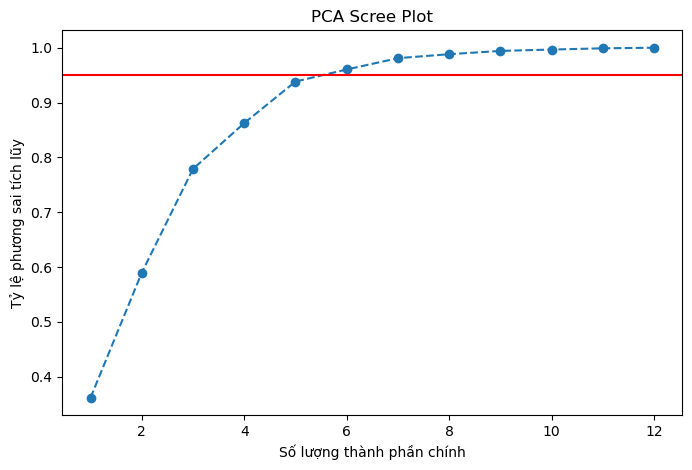

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Chuẩn hóa dữ liệu trước khi áp dụng PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Áp dụng PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# Tính phần trăm phương sai được giữ lại
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Vẽ biểu đồ Scree Plot để chọn số thành phần chính
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-')  # Ngưỡng 95% phương sai
plt.xlabel('Số lượng thành phần chính')
plt.ylabel('Tỷ lệ phương sai tích lũy')
plt.title('PCA Scree Plot')
plt.show()


In [18]:
# Chọn số lượng thành phần chính giữ lại 95% phương sai
optimal_components = np.argmax(explained_variance_ratio >= 0.95) + 1
print(f"Số lượng thành phần chính tối ưu: {optimal_components}")

# Áp dụng PCA với số lượng thành phần chính tối ưu
pca = PCA(n_components=optimal_components)
X_train_pca_selected = pca.fit_transform(X_train_scaled)

# Áp dụng PCA cho X_val và X_test
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)
models = {
    "SVM": SVC(kernel='rbf', C=10, degree=5, gamma='auto', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7, weights='distance', p=2),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=300, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42)
}

# ✅ Soft Voting (Trung bình xác suất dự đoán)
soft_voting = VotingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    voting='soft'
)

# ✅ Hard Voting (Dự đoán theo đa số)
hard_voting = VotingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    voting='hard'
)

# ✅ Weighted Voting (Gán trọng số cho mô hình)
weights = [2, 1, 3, 3, 1, 2]  
weighted_voting = VotingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    voting='soft',
    weights=weights
)

# ✅ Stacking với Logistic Regression
stacking_lr = StackingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    final_estimator=LogisticRegression(random_state=42)
)

# ✅ Stacking với Random Forest
stacking_rf = StackingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42)
)

# ✅ Stacking với Extra Trees
stacking_extra = StackingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    final_estimator=ExtraTreesClassifier(n_estimators=100, random_state=42)
)

# ✅ Đánh giá các mô hình ensemble
ensemble_models = {
    "Soft Voting": soft_voting,
    "Hard Voting": hard_voting,
    "Weighted Voting": weighted_voting,
    "Stacking (LR)": stacking_lr,
    "Stacking (RF)": stacking_rf,
    "Stacking (Extra Tree)": stacking_extra
}

for name, model in {**models, **ensemble_models}.items():
    model.fit(X_train_pca_selected, y_train)
    
    # Đánh giá trên tập validation
    y_val_pred = model.predict(X_val_pca)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')
    print(f"{name} (Validation): Accuracy = {val_accuracy:.4f}, F1-score = {val_f1:.4f}")
    
    # Đánh giá trên tập test
    y_test_pred = model.predict(X_test_pca)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    print(f"{name} (Test): Accuracy = {test_accuracy:.4f}, F1-score = {test_f1:.4f}")

Số lượng thành phần chính tối ưu: 6
SVM (Validation): Accuracy = 0.5424, F1-score = 0.5347
SVM (Test): Accuracy = 0.9102, F1-score = 0.9102
KNN (Validation): Accuracy = 0.5219, F1-score = 0.5155
KNN (Test): Accuracy = 0.9144, F1-score = 0.9144
Random Forest (Validation): Accuracy = 0.5365, F1-score = 0.5302
Random Forest (Test): Accuracy = 0.9183, F1-score = 0.9183
Gradient Boosting (Validation): Accuracy = 0.5383, F1-score = 0.5278
Gradient Boosting (Test): Accuracy = 0.9129, F1-score = 0.9129
Naive Bayes (Validation): Accuracy = 0.4437, F1-score = 0.4359
Naive Bayes (Test): Accuracy = 0.9493, F1-score = 0.9492
Extra Trees (Validation): Accuracy = 0.5307, F1-score = 0.5255
Extra Trees (Test): Accuracy = 0.9229, F1-score = 0.9228
Soft Voting (Validation): Accuracy = 0.5172, F1-score = 0.5097
Soft Voting (Test): Accuracy = 0.9309, F1-score = 0.9309
Hard Voting (Validation): Accuracy = 0.5199, F1-score = 0.5099
Hard Voting (Test): Accuracy = 0.9269, F1-score = 0.9269
Weighted Voting (Val